In [1]:
import numpy as np
import scipy as sc
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd
import IPython.display as ipd

In [2]:
Fs, audio_dat = wavfile.read('data/MS-SNSD/clean_test/clnsp3.wav')
audio_dat = audio_dat/np.max(audio_dat)
Fs = 16e3
time = np.linspace(0, len(audio_dat)/Fs, len(audio_dat))

clean_speech_var = np.linalg.norm(audio_dat - np.mean(audio_dat))**2
ipd.Audio(audio_dat, rate = Fs)

Text(0, 0.5, 'Bits')

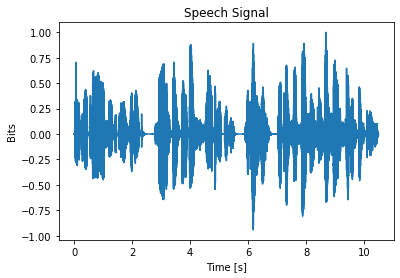

In [3]:
plt.figure(1)
plt.plot(time, audio_dat)
plt.title('Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Bits')

## Four Element Microphone Array Locations

[-4, 4, 0, 4]

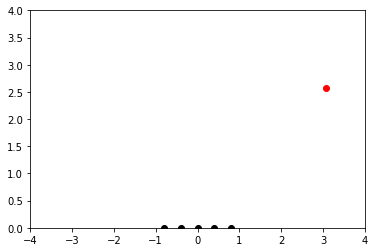

In [268]:
# Best combination - (d, broadside_angle)
# (0.3, 30), (0.3, -30)

d = 40/100 
N = 5
pn = np.zeros([3, N])
pn[0, 0:N] = (np.linspace(1, N, N) - (N + 1)/2)*d
Rad = 4
broadside_angle = 50

src_loc = np.array([Rad*np.sin(np.deg2rad(broadside_angle)), Rad*np.cos(np.deg2rad(broadside_angle)), 0])

plt.figure()
plt.plot(pn[0, :], pn[1, :], 'ko')
plt.plot(src_loc[0], src_loc[1], 'ro')
plt.axis([-Rad, Rad, 0, Rad])

## Propagate Speech Signal to 4 microphone array

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


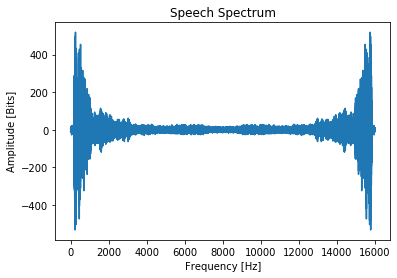

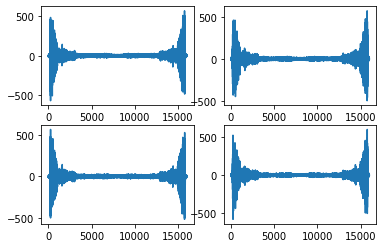

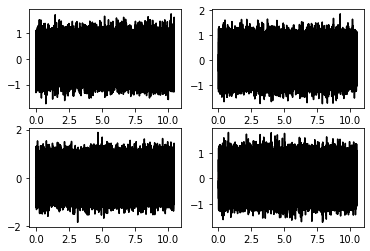

In [269]:
fft_speech = sc.fft(audio_dat)
F = np.linspace(0, Fs, len(audio_dat))

plt.figure(2)
plt.plot(F, fft_speech)
plt.title('Speech Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [Bits]')

# Propagating each frequency component to the specific location
sensor_sig_fft = np.zeros([N, len(F)], dtype = np.complex64)
sensor_sig = np.zeros([N, len(F)], dtype = np.complex64)
noise = np.zeros([N, len(F)], dtype = np.float64)
sensor_var = np.zeros(N)
sensor_noise_var = np.zeros(N)
sensor_collected_var = np.zeros(N)
noise_amp = np.zeros(N)
sensor_rms_amp = np.zeros(N)
snr = -10

c = 343 # Speed of sound
kappa_vec = 2*np.pi*F/c # Kappa Vec

for n in range(0, N):
    rn = np.linalg.norm(pn[:, n] - src_loc)
    sensor_sig_fft[n, :] = fft_speech*np.exp(1j*kappa_vec*rn)
    temp = sc.ifft(sensor_sig_fft[n, :])
    sensor_var[n] = np.linalg.norm(temp - np.mean(temp))**2
    sensor_rms_amp[n] = np.sqrt(np.mean(np.abs(temp)**2))
    noise_amp[n] = sensor_rms_amp[n]/(10**(snr/20))
    
    noise[n, :] = noise_amp[n]*np.random.normal(0, 1, len(time))
    
    sensor_sig[n, :] = temp + noise[n, :]
    sensor_noise_var[n] = np.linalg.norm(noise[n, :] - np.mean(noise[n, :]))**2
    sensor_collected_var = np.linalg.norm(sensor_sig[n, :] - np.mean(sensor_sig[n, :]))**2
    temp = np.zeros(shape = time.shape)
    
plt.figure(3)
plt.subplot(2, 2, 1)
plt.plot(F, np.real(sensor_sig_fft[0]))
plt.subplot(2, 2, 2)
plt.plot(F, np.real(sensor_sig_fft[1]))
plt.subplot(2, 2, 3)
plt.plot(F, np.real(sensor_sig_fft[2]))
plt.subplot(2, 2, 4)
plt.plot(F, np.real(sensor_sig_fft[3]))

plt.figure(4)
plt.subplot(2, 2, 1)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[0]), 'k')

plt.subplot(2, 2, 2)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[1]), 'k')

plt.subplot(2, 2, 3)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[2]), 'k')

plt.subplot(2, 2, 4)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[3]), 'k')

In [270]:
computed_SNR = 10*np.log10(sensor_var/sensor_noise_var)
print(computed_SNR)
print(noise_amp)
print(sensor_rms_amp)

[-9.99319498 -9.99929803 -9.99436675 -9.9984816  -9.98509289]
[0.39305548 0.39305553 0.3930555  0.3930555  0.39305545]
[0.12429506 0.12429507 0.12429506 0.12429506 0.12429505]


### Mic 1 Audio Playback

In [271]:
ipd.Audio(np.real(sensor_sig[0]), rate = Fs, normalize=True)

### Mic 2 Audio Playback

In [272]:
ipd.Audio(np.real(sensor_sig[1]), rate = Fs, normalize=True)

### Mic 3 Audio Playback

In [273]:
ipd.Audio(np.real(sensor_sig[2]), rate = Fs, normalize=True)

### Mic 4 Audio Playback

In [274]:
ipd.Audio(np.real(sensor_sig[3]), rate = Fs, normalize=True)

## Source localization - GCC PHAT

In [275]:
def gccphat(Refsig, Sig, fs, d, interp = 16, c = 343):
    max_tau = None
    sig1 = Refsig
    sig2 = Sig
    m_len = len(sig1) + len(sig2)

    sig = sc.fft(sig2, n = m_len)
    refsig = sc.fft(sig1, n = m_len)

    R = sig*np.conj(refsig)

    cc = sc.ifft(R/np.abs(R), n = interp*m_len)
    max_shift = int(interp*m_len/2)

    if max_tau:
        max_shift = np.minimum(int(interp*fs*max_tau), max_shift)
    
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    shift = np.argmax(np.abs(cc)) - max_shift
    tau = shift/float(interp*fs)
    aoa = np.arcsin(c*tau/d) # Angle of arrival
    return aoa, tau, cc

Angle of Arrival:50.0


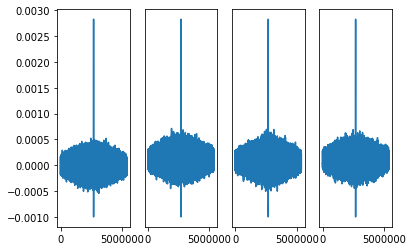

In [276]:
aoa = np.zeros(shape = (N - 1))
tau = np.zeros(shape = (N - 1))
cc = np.zeros(shape = (N - 1, 2*len(time)*16 + 1), dtype = np.complex64)

for m in range(0, N-1):
    aoa[m], tau[m], cc[m, :] = gccphat(sensor_sig[m], sensor_sig[m+1], Fs, d, interp = 16, c = 343)
    
angle_est = np.round(np.mean(aoa*180/np.pi))
print('Angle of Arrival:' + str(angle_est))

plt.figure()
for m in range(0, N - 1):
    plt.subplot(1, N-1, m+1)
    plt.plot(cc[m, :])
    
    if (m != 0):
        plt.yticks([])

In [277]:
frame_len = len(time)
frame_shift = len(time)/2

num_frames = int(len(time)/frame_len)
print(num_frames)

1


## Calculate Spatial/Sample covariance matrix

In [278]:
R_mean = np.zeros(shape = (N, N, fft_len), dtype = np.complex64)
mu = 1e10

for f in range(0, frame_len):
    R_mean[:, :, f] = mu*np.eye(N)

In [279]:
fft_len = frame_len
fft_shift = frame_shift
use_num_frames_init = num_frames
use_num_frames_final = num_frames

start_ind = 0
end_ind = start_ind + fft_len

freq_grid = np.linspace(0, Fs, fft_len)

speech_len = len(sensor_sig)
used_frames = 0

# forward
for _ in range (0, use_num_frames_init):
    s = np.real(sensor_sig[:, start_ind:end_ind])
    s_fft = sc.fft(s, n = fft_len)

    for f in range(0, fft_len):
        R_mean[:, :, f] = R_mean[:, :, f] + np.multiply.outer(s_fft[:, f], np.conj(s_fft[:, f]).T)
    used_frames = used_frames + 1
    start_ind = start_ind + fft_shift
    end_ind = end_ind + fft_shift
    
    
    
    if speech_len<= start_ind or speech_len <= end_ind:
        used_frames = used_frames - 1
        break
        
end_ind = speech_len
start_ind = end_ind - fft_len

#backward
for _ in range(0, use_num_frames_final):
    s = np.real(sensor_sig[:, start_ind:end_ind])
    s_fft = sc.fft(s, n = fft_len)
    
    for f in range(0, fft_len):
        R_mean[:, :, f] = R_mean[:, :, f] + np.multiply.outer(s_fft[:, f], np.conj(s_fft[:, f]).T)
    used_frames = used_frames + 1
    start_ind = start_ind - fft_shift
    end_ind = end_ind - fft_shift
    
    if speech_len<= start_ind or speech_len <= end_ind:
        used_frames = used_frames - 1
        break
    

In [280]:
look_dir = angle_est*np.pi/180
kappa_vec = 2*np.pi*freq_grid/c
steer_vec = np.zeros(shape = (N, fft_len), dtype = np.complex64)
collected_sig_fft = np.zeros(shape = (N, fft_len), dtype = np.complex64)

for m in range(0, N):
    steer_vec[m, :] = np.exp(-1j*kappa_vec*(np.sin(look_dir))*pn[0, m]) 
    collected_sig_fft[m, :] = sc.fft(sensor_sig[m, 0:fft_len])


In [281]:
E, V = np.linalg.eig(np.transpose(R_mean, (2, 0, 1)))

In [282]:
W = np.zeros(shape = (N, fft_len), dtype = np.complex64)
y_fft = np.zeros(shape = fft_len, dtype = np.complex64)

for f in range (0, fft_len):
    #Rxx_inv = np.diag(E[f, :])
    Rxx_inv = np.linalg.pinv(R_mean[:, :, f])
    alpha = 1/np.matmul(np.matmul(np.conjugate(steer_vec[:, f]), Rxx_inv), steer_vec[:, f])
    W[:, f] = alpha*np.matmul(Rxx_inv, steer_vec[:, f])
    
    y_fft[f] = np.matmul(np.transpose(np.conjugate(W[:, f])), collected_sig_fft[:, f])

In [283]:
y = sc.ifft(y_fft, n = fft_len)

In [284]:
ipd.Audio(np.real(y), rate = Fs, normalize=True)